<a href="https://colab.research.google.com/github/sid-betalol/Neural-Collapse-and-Class-Hierarchy/blob/main/hierarchical_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Better Mistakes using Hierarchical Loss Functions

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from nltk.tree import Tree
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## CIFAR-10 Classes and Hierarchy

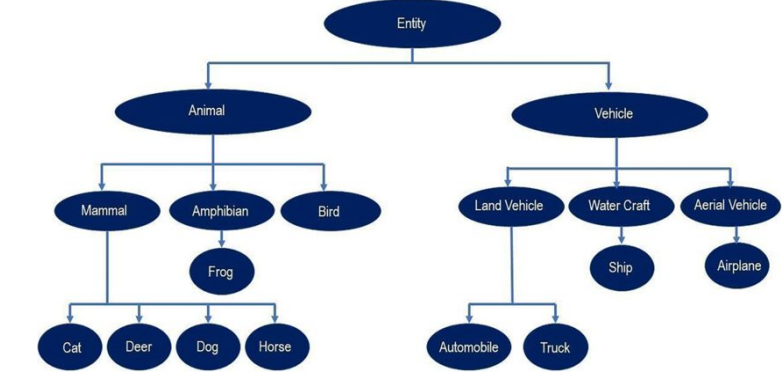

In [ ]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifar10_hierarchy = Tree('Entity', [Tree('Animal', [Tree('Mammal', ['cat', 'deer', 'dog', 'horse']),
                                                     'frog',
                                                     'bird']),
                                    Tree('Vehicle', [Tree('Land Vehicle', ['automobile', 'truck']),
                                                     'ship',
                                                     'airplane'])])

## The Hierarchical Loss function

In [ ]:
def treepositions_for_leaves(hierarchy: Tree, class_name: str):
    for pos in hierarchy.treepositions('leaves'):
        if hierarchy[pos] == class_name:
            path = [class_name]
            while pos:
                pos = pos[:-1]
                node = hierarchy[pos]
                if isinstance(node, Tree):
                    path.append(node.label())
            return path[::-1]
    raise ValueError(f"Class name {class_name} not found in hierarchy")

class HierarchicalCrossEntropyLoss(nn.Module):
    def __init__(self, hierarchy: Tree, classes: List[str], alpha: float = 1.0):
        super().__init__()
        self.hierarchy = hierarchy
        self.classes = classes
        self.alpha = torch.tensor([alpha], dtype=torch.float, requires_grad=False).to(device)

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        loss = torch.zeros(1, device=inputs.device)
        for i, target in enumerate(targets):
            class_name = self.classes[target.item()]
            path = treepositions_for_leaves(self.hierarchy, class_name)
            for depth, node_label in enumerate(path):
                if node_label in self.classes:
                    class_idx = self.classes.index(node_label)
                    depth_tensor = torch.tensor([depth], dtype=torch.float, requires_grad = False).to(device)
                    weight = torch.exp(-self.alpha * depth_tensor)
                    loss = loss - weight * log_probs[i, class_idx]

        return loss.mean()

class SoftCrossEntropyLoss(nn.Module):
   def __init__(self, soft_y):
      super().__init__()
      self.soft_y = soft_y

   def forward(self, y_hat, y):
      # print("YYYY",y,y_hat)
      p = F.log_softmax(y_hat, dim=1).to(device) # y_hat is the output labels, we apply softmax to make it a probability and log since that's how entropy works.
      weights = torch.transpose(soft_y[:,y.cpu()],0,1).to(device)
      # print(weights.shape,y_hat.shape)
      loss = -(weights*p).sum().to(device)
      return loss

We need to make a matrix that contains all the weights of every (A,C) pair in the tree. We can then use this.

In [ ]:
import math
beta = 0.5 #Tune this as a hyperparameter
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
soft_y = torch.zeros((10,10),device='cpu')
dist = torch.zeros((10,10),device='cpu')
hTree = 4
hLca = torch.tensor([[0, 2, 3, 3, 3, 3, 3, 3, 2, 2],
[2, 0, 3, 3, 3, 3, 3, 3, 2, 1],
[3, 3, 0, 2, 2, 2, 2, 2, 3, 3],
[3, 3, 2, 0, 1, 1, 2, 1, 3, 3],
[3, 3, 2, 1, 0, 1, 2, 1, 3, 3],
[3, 3, 2, 1, 1, 0, 2, 1, 3, 3],
[3, 3, 2, 2, 2, 2, 0, 2, 3, 3],
[3, 3, 2, 1, 1, 1, 2, 0, 3, 3],
[2, 2, 3, 3, 3, 3, 3, 3, 0, 2],
[2, 1, 3, 3, 3, 3, 3, 3, 2, 0]]).to(device)

for i in range(hLca.shape[0]):
  for j in range(hLca.shape[1]):
    dist[i][j]=hLca[i][j]/hTree

for i in range(soft_y.shape[1]):
  sum_i = 0
  for j in range(soft_y.shape[0]):
    sum_i=sum_i+math.exp(-beta*dist[j][i])

  for j in range(soft_y.shape[0]):
    soft_y[j][i] = math.exp(-beta*dist[j][i])/sum_i

soft_y

tensor([[0.1340, 0.1030, 0.0899, 0.0864, 0.0864, 0.0864, 0.0899, 0.0864, 0.1044,
         0.1030],
        [0.1044, 0.1322, 0.0899, 0.0864, 0.0864, 0.0864, 0.0899, 0.0864, 0.1044,
         0.1167],
        [0.0921, 0.0909, 0.1308, 0.0979, 0.0979, 0.0979, 0.1019, 0.0979, 0.0921,
         0.0909],
        [0.0921, 0.0909, 0.1019, 0.1257, 0.1109, 0.1109, 0.1019, 0.1109, 0.0921,
         0.0909],
        [0.0921, 0.0909, 0.1019, 0.1109, 0.1257, 0.1109, 0.1019, 0.1109, 0.0921,
         0.0909],
        [0.0921, 0.0909, 0.1019, 0.1109, 0.1109, 0.1257, 0.1019, 0.1109, 0.0921,
         0.0909],
        [0.0921, 0.0909, 0.1019, 0.0979, 0.0979, 0.0979, 0.1308, 0.0979, 0.0921,
         0.0909],
        [0.0921, 0.0909, 0.1019, 0.1109, 0.1109, 0.1109, 0.1019, 0.1257, 0.0921,
         0.0909],
        [0.1044, 0.1030, 0.0899, 0.0864, 0.0864, 0.0864, 0.0899, 0.0864, 0.1340,
         0.1030],
        [0.1044, 0.1167, 0.0899, 0.0864, 0.0864, 0.0864, 0.0899, 0.0864, 0.1044,
         0.1322]])

## Simple CNN

We deliberately choose a simple architecture so that the model makes mistakes and we can compare if with the Hierarchical loss function, we make better ones

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Loading the dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

100%|██████████| 170498071/170498071 [00:10<00:00, 15940598.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Setting up the models: Conventional Cross Entropy and Hierarchical Cross Entropy

In [ ]:
net1 = SimpleCNN().to(device)
net2 = SimpleCNN().to(device)

In [ ]:
criterion_standard = nn.CrossEntropyLoss()
criterion_hierarchical = HierarchicalCrossEntropyLoss(cifar10_hierarchy, cifar10_classes, alpha=1.0)
criterion_softlabel = SoftCrossEntropyLoss(soft_y)

In [ ]:
optimizer1 = torch.optim.Adam(net1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.01)

## Training and testing code

In [ ]:
def train_model(net, criterion, optimizer, trainloader, epochs):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                avg_loss = running_loss / 2000
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.6f}')
                running_loss = 0.0
    print('Finished Training')

In [ ]:
def evaluate_model(net, testloader, classes):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Training both the models

In [ ]:
epochs = 8

print("Training with standard cross-entropy loss")
train_model(net1, criterion_standard, optimizer1, trainloader, epochs)

# print("Training with soft labels cross-entropy loss")
# train_model(net2, criterion_softlabel, optimizer2, trainloader, epochs)

Training with standard cross-entropy loss
[1,  2000] loss: 1.622776
[1,  4000] loss: 1.338428
[1,  6000] loss: 1.212924
[1,  8000] loss: 1.146821
[1, 10000] loss: 1.092082
[1, 12000] loss: 1.058961
[2,  2000] loss: 0.907317
[2,  4000] loss: 0.911550
[2,  6000] loss: 0.922288
[2,  8000] loss: 0.912810
[2, 10000] loss: 0.879924
[2, 12000] loss: 0.870185
[3,  2000] loss: 0.726556
[3,  4000] loss: 0.742730
[3,  6000] loss: 0.723842
[3,  8000] loss: 0.739305
[3, 10000] loss: 0.735692
[3, 12000] loss: 0.761800
[4,  2000] loss: 0.550807
[4,  4000] loss: 0.578188
[4,  6000] loss: 0.590029
[4,  8000] loss: 0.620373
[4, 10000] loss: 0.641780
[4, 12000] loss: 0.610398
[5,  2000] loss: 0.399832
[5,  4000] loss: 0.451538
[5,  6000] loss: 0.470628
[5,  8000] loss: 0.484656
[5, 10000] loss: 0.517743
[5, 12000] loss: 0.525574
[6,  2000] loss: 0.313622
[6,  4000] loss: 0.346786
[6,  6000] loss: 0.371564
[6,  8000] loss: 0.401501
[6, 10000] loss: 0.404452
[6, 12000] loss: 0.408646
[7,  2000] loss: 0.238

In [ ]:
y = torch.tensor([8, 7, 7, 2])
soft_y[8] # represents all the P(Class=8)

tensor([0.1044, 0.1030, 0.0899, 0.0864, 0.0864, 0.0864, 0.0899, 0.0864, 0.1340,
        0.1030])

In [ ]:
y = torch.tensor([2, 3, 9, 5], device='cuda:0')
y_hat = torch.tensor([[ 0.0299,  0.0197, -0.0415, -0.0032,  0.0110, -0.0624,  0.0219, -0.0678,
         -0.0717,  0.0023],
        [ 0.0020,  0.0366, -0.0309,  0.0335, -0.0073, -0.0861, -0.0157, -0.0388,
         -0.0830, -0.0187],
        [ 0.0264,  0.0219,  0.0079,  0.0157, -0.0045, -0.0271,  0.0345, -0.0762,
         -0.0686, -0.0283],
        [ 0.0015,  0.0230, -0.0373,  0.0239, -0.0010, -0.0664,  0.0060,  0.0040,
         -0.0625, -0.0231]], device='cuda:0')
p = F.log_softmax(y_hat, dim=1).to(device) # y_hat is the output labels, we apply softmax to make it a probability and log since that's how entropy works.
weights = torch.transpose(soft_y[:,y.cpu()],0,1).to(device)
print(weights.shape,y_hat.shape)
loss = -(weights*p).sum().to(device)
print(loss)

torch.Size([4, 10]) torch.Size([4, 10])
tensor(9.2146, device='cuda:0')


## Evaluating both the models

In [ ]:
# print("Evaluating the standard CE model")
# evaluate_model(net1, testloader, cifar10_classes)

Evaluating the hierarchical CE model


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.13      0.01      0.01      1000
        bird       0.11      0.52      0.18      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.08      0.16      0.10      1000
        frog       0.04      0.00      0.01      1000
       horse       0.12      0.36      0.17      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.05      0.10      0.05     10000
weighted avg       0.05      0.10      0.05     10000



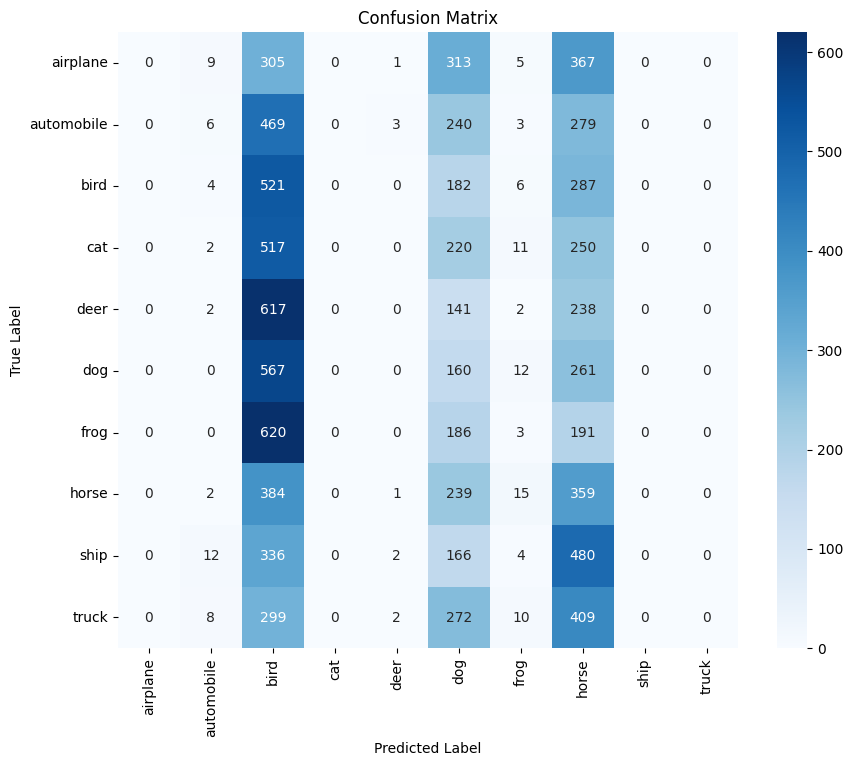

In [ ]:
print("Evaluating the hierarchical CE model")
evaluate_model(net2, testloader, cifar10_classes)

## Visualizing NC properties